In [45]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid 
from sklearn.model_selection import train_test_split

In [46]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

dataset = Planetoid(root='data/Planetoid/Cora', name='Cora')

In [47]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/PubMed', name='PubMed')


In [48]:
data = dataset[0]  

G = to_networkx(data, to_undirected=True) 

In [131]:
G=nx.Graph()
G.add_edge(0,1)
G.add_edge(1,2)
G.add_edge(2,0)
G.add_edge(2,3)
G.add_edge(3,4)
G.add_edge(4,5)
G.add_edge(5,3)
G.add_edge(6,2)
G.add_edge(6,3)

In [132]:
G.adjacency()

In [133]:
noice=G.number_of_nodes()

In [134]:
G.number_of_nodes()

7

In [135]:
import networkx as nx
from networkx.algorithms.clique import find_cliques
max=G.number_of_nodes()
cliques = list(find_cliques(G))
lol =dict()
virtual_nodes = dict()
print(f"Number of cliques in the Karate Club graph: {len(cliques)}")
for i, clique in enumerate(cliques):
    if len(clique)==3:
        #rule1
        lol[max]=clique  
        #rule2
        virtual_nodes[max]=clique
        flag=clique
        for j in clique:
            virtual_nodes[max]=virtual_nodes[max]+list(G.neighbors(j))
            # flag=flag+list(G.neighbors(j))
        virtual_nodes[max]=list(set(virtual_nodes[max]))        
        print(f"Clique {max}: {clique}")
        print(f"Node {max} has neighbors: {virtual_nodes[max]}")
        max=max+1




Number of cliques in the Karate Club graph: 3
Clique 7: [2, 0, 1]
Node 7 has neighbors: [0, 1, 2, 3, 6]
Clique 8: [2, 3, 6]
Node 8 has neighbors: [0, 1, 2, 3, 4, 5, 6]
Clique 9: [4, 3, 5]
Node 9 has neighbors: [2, 3, 4, 5, 6]


In [136]:
#rule3
count=0
for i in lol.keys():
    for j in lol.keys():
        if i!=j:
            if len(set(lol[i]).intersection(set(lol[j])))!=0:
                count=count+1
                virtual_nodes[i].append(j)
                virtual_nodes[j].append(i)
print(count)

4


In [137]:
for i in virtual_nodes.keys():
    for j in virtual_nodes[i]:
        G.add_edge(i,j) 

In [138]:
G.number_of_nodes()

10

In [139]:
print(f'Number of nodes: {dataset[0].num_nodes}')

Number of nodes: 19717


In [140]:
noice

7

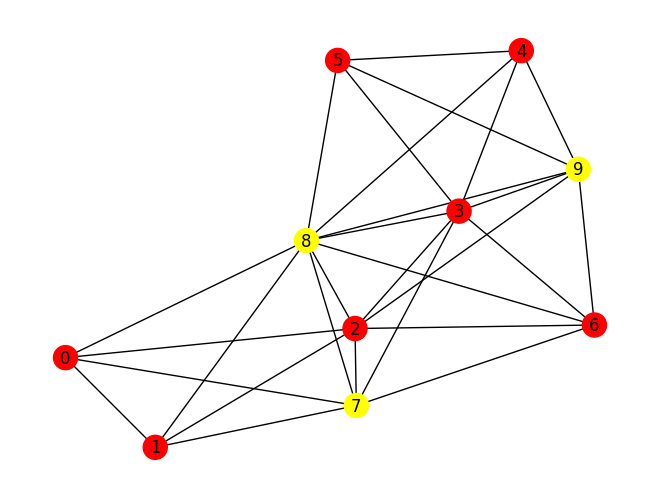

In [ ]:
node_color = ['yellow' if node_id > noice-1  else 'red' for node_id in G]


nx.draw(G, node_color=node_color, with_labels=True)
plt.show()

feature aggrigation


In [58]:
x=torch.zeros(1433)

In [60]:
for i in lol:
    x=torch.zeros(500)
    for j in lol[i]:
        x=data.x[j]+x
    data.x=torch.cat((data.x,x.unsqueeze(0)),0)

In [61]:
data.edge_index

tensor([[ 1378,  1544,  6092,  ..., 12278,  4284, 16030],
        [    0,     0,     0,  ..., 19714, 19715, 19716]])

In [62]:
edge_list=nx.to_edgelist(G)
edge_index = torch.tensor([[edge[0], edge[1]] for edge in edge_list], dtype=torch.long).t().contiguous()
print(edge_index)

tensor([[    0,     0,     0,  ..., 19715, 19715, 19715],
        [ 1378,  1544,  6092,  ..., 22915, 22985, 22986]])


In [63]:
data.edge_index=edge_index

Model prep

In [64]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = Net()

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [68]:
model = Net()

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    optimizer.zero_grad() 
    out = model(data.x, data.edge_index) 
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  
    loss.backward()  
    optimizer.step()  

IndexError: The shape of the mask [19717] at index 0 does not match the shape of the indexed tensor [26142, 3] at index 0

In [65]:
embeddings = model(data.x, data.edge_index)

print(embeddings)

tensor([[-1.1085, -1.0808, -1.1068],
        [-1.0967, -1.1013, -1.0978],
        [-1.1422, -1.0989, -1.0566],
        ...,
        [-1.1610, -1.1110, -1.0284],
        [-1.1660, -1.1408, -0.9974],
        [-1.1606, -1.1532, -0.9914]], grad_fn=<LogSoftmaxBackward0>)


In [66]:
embeddings.shape

torch.Size([26142, 3])